<a href="https://colab.research.google.com/github/kylematoba/deeplearning-project/blob/master/keras_wide_res_net_matoba.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
# A heavily modified version of https://github.com/tail-island/try-wide-residual-net
!pip3 install funcy
!pip3 install tqdm
# !pip3 install tensorboard
# !pip3 install npm
# !pip3 install tensorboardcolab

# !pip3 install pydot
# !pip3 install pydot_ng
# !pip3 install pydotplus
# !pip3 install graphviz

In [0]:
# !ls
# from tensorboardcolab import *
# tbc = TensorBoardColab()
# tbc = TensorBoardColab(startup_waiting_time=8)

In [0]:
import os
import sys
import shutil
import pickle
import copy
import logging

from typing import List, Tuple
from operator import getitem, attrgetter
from collections import namedtuple

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

import keras

from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.layers import Activation, Add, BatchNormalization, Conv2D, Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model, save_model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
# from tensorflow.keras.utils import plot_model

from tqdm import tqdm
from funcy import concat, identity, juxt, partial, rcompose, repeat, repeatedly, take

# from google.colab import drive
import google.colab
from google.colab import auth
from googleapiclient.discovery import build
from googleapiclient.http import MediaFileUpload, MediaIoBaseDownload

In [3]:
FORMAT = "%(asctime)s %(process)s %(thread)s: %(message)s"
logging.basicConfig(level=logging.DEBUG, format=FORMAT, stream=sys.stdout)
logger = logging.getLogger(__name__)

environ_dict = dict(os.environ)
use_tpu = 'COLAB_TPU_ADDR' in environ_dict.keys()

logger.info(sys.version)
logger.info("{}".format("Running in ipython" if 'ipykernel' in sys.modules else ""))
logger.info("Numpy version {}".format(np.__version__))
logger.info("TensorFlow version {}".format(tf.__version__))
logger.info("Keras version {}".format(keras.__version__))
if use_tpu:
    logger.info("Running on TPU")

2018-12-01 08:29:52,368 60 140567285913472: 3.6.7 (default, Oct 22 2018, 11:32:17) 
[GCC 8.2.0]
2018-12-01 08:29:52,370 60 140567285913472: Running in ipython
2018-12-01 08:29:52,372 60 140567285913472: Numpy version 1.14.6
2018-12-01 08:29:52,374 60 140567285913472: TensorFlow version 1.12.0
2018-12-01 08:29:52,376 60 140567285913472: Keras version 2.2.4
2018-12-01 08:29:52,377 60 140567285913472: Running on TPU


In [0]:
np.random.seed(0)

In [0]:

# mount_loc = '/content/gdrive'
# force_remount = True
# google.colab.drive.mount(mount_loc, force_remount=force_remount)


In [0]:
# !ls gdrive/'My Drive'
# os.chdir('./gdrive/My Drive')
# !pwd
# os.listdir('./')
# !cd gdrive/'My Drive'
# !ls ./
# # !ls $mount_loc/'My Drive'
# # !mv $mount_loc/'My Drive' $mount_loc/my_drive
# my_drive = os.path.join(mount_loc, 'My\ Drive')
# local_home = "./local_home"
# os.makedirs(local_home, exist_ok=True)
# symlink_name = os.path.join(mount_loc, 'my_drive')
# # symlink_name = local_home
# # !ln -s $my_drive $symlink_name
# # !cd $symlink_name
# !cd $my_drive

In [0]:
# # !ls $my_drive
# !cd $my_drive
# !ls
# # !ls 
# # !ls ./local_home
# # !ls $my_drive
# # symlink_name

In [5]:
# model_name = 'wide_resnet_matoba'
# mount_loc = './local_home/my_drive'
# mount_loc = os.path.join(local_home, symlink_name)
# checkpoint_dir = os.path.join(my_drive, model_name)
# checkpoint_dir = os.path.join('./', model_name)
# logger.info("Creating checkpoint location {}".format(checkpoint_dir))
# os.makedirs(checkpoint_dir, exist_ok=True)

2018-12-01 08:30:01,357 60 140567285913472: Creating checkpoint location ./wide_resnet_matoba


In [0]:
def download_data() -> None:
    url = 'http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz'
    shutil.copytree(keras.utils.data_utils.get_file('cifar-10-batches-py', origin=url, untar=True), './data')

    
def load_batch(batch_path: str) -> Tuple[np.ndarray, np.ndarray]:
    with open(batch_path, 'rb') as f:
        batch = pickle.load(f, encoding='bytes')
    data_np = np.array(batch[b'data'])
    labels_np = np.array(batch[b'labels'])
    batch_data = data_np.reshape(data_np.shape[0], 3, 32, 32).transpose(0, 2, 3, 1) / 255
    batch_labels = keras.utils.to_categorical(labels_np)
    return (batch_data, batch_labels)


def load_batches(paths: List[str]):
    return tuple(map(np.concatenate, zip(*map(load_batch, paths))))


def load_data(data_path='./data') -> Tuple[np.ndarray, np.ndarray]:
    if not os.path.exists('./data'):
        download_data()
    paths = sorted(map(attrgetter('path'), filter(lambda directory_entry: directory_entry.name.startswith('data_batch_'), os.scandir(data_path))))
    xy_train = load_batches(paths)
    xy_validation = load_batch('{0}/test_batch'.format(data_path))
    return (xy_train, xy_validation)

In [0]:
# if not os.path.exists('./data'):
#     download_data()

# data_path='./data'
# paths = sorted(map(attrgetter('path'), filter(lambda directory_entry: directory_entry.name.startswith('data_batch_'), os.scandir(data_path))))
# # print(paths)


# batch_path = paths[0]
# with open(batch_path, 'rb') as f:
#     batch = pickle.load(f, encoding='bytes')
# d = batch[b'data']
# l = batch[b'labels']

In [0]:
def computational_graph(class_size):
    def ljuxt(*fs):
        return rcompose(juxt(*fs), list)

    def batch_normalization():
        return BatchNormalization()

    def relu():
        return Activation('relu')

    def conv(filter_size, kernel_size, stride_size=1):
        return Conv2D(filter_size, kernel_size, strides=stride_size, padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.0005), use_bias=False)

    def add():
        return Add()

    def global_average_pooling():
        return GlobalAveragePooling2D()

    def dense(unit_size, activation):
        return Dense(unit_size, activation=activation, kernel_regularizer=l2(0.0005))

    # Define WRN-28-10.
    def first_residual_unit(filter_size, stride_size):
        return rcompose(batch_normalization(),
                        relu(),
                        ljuxt(rcompose(conv(filter_size, 3, stride_size),
                                       batch_normalization(),
                                       relu(),
                                       conv(filter_size, 3, 1)),
                              rcompose(conv(filter_size, 1, stride_size))),
                        add())

    def residual_unit(filter_size):
        return rcompose(ljuxt(rcompose(batch_normalization(),
                                       relu(),
                                       conv(filter_size, 3),
                                       batch_normalization(),
                                       relu(),
                                       conv(filter_size, 3)),
                              identity),
                        add())

    def residual_block(filter_size, stride_size, unit_size):
        return rcompose(first_residual_unit(filter_size, stride_size),
                        rcompose(*repeatedly(partial(residual_unit, filter_size), unit_size - 1)))

    k = 10
    n =  4

    return rcompose(conv(16, 3),
                    residual_block(16 * k, 1, n),
                    residual_block(32 * k, 2, n),
                    residual_block(64 * k, 2, n),
                    batch_normalization(),
                    relu(),
                    global_average_pooling(),
                    dense(class_size, 'softmax'))

In [9]:
batch_size = 128
epochs = 200
checkpoint_period = 5

(x_train, y_train), (x_validation, y_validation) = load_data()
# print(x_train.shape)
# print(x_validation.shape)

170500096/170498071 [==============================] - 6s 0us/step


Text(0.5,1,"['deer']")

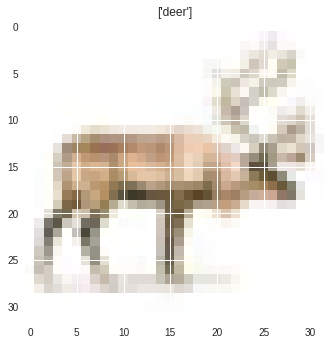

In [11]:
CLASS_LABELS = np.array(['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'forse', 'ship', 'truck'])

train_set_size = x_train.shape[0]
# idx = 1000
idx = np.random.randint(train_set_size)
label = CLASS_LABELS[y_train[idx, :].astype(bool)]
plt.imshow(x_train[idx, :, :, :])
plt.title(label)

In [14]:
# checkpoint_dir = checkpoint_dir
# checkpoint_pattern = "{epoch:03d}.ckpt"
# checkpoint_fullfile = os.path.join(checkpoint_dir, checkpoint_pattern)
# logger.info(checkpoint_fullfile)
# checkpoint_path = "checkpoints/{epoch:03d}.ckpt"
# checkpoint_dir = os.path.dirname(checkpoint_path)
# logger.info("Creating checkpoint location {}".format())
# os.makedirs(checkpoint_dir, exist_ok=True)


# latest = tf.train.latest_checkpoint(checkpoint_dir)
# if latest is not None:  # this is actually the better way to do it by far, as it doesn't entail the costly process of re-loading inside of the loop
#     logger.info("Restoring model from {}".format(latest))
#     model.load_weights(latest)
# print(latest)

2018-11-30 08:00:39,028 59 140669153396608: ./wide_resnet_matoba/{epoch:03d}.ckpt
None


In [0]:
def good_policies():
    """AutoAugment policies found on analysis."""
    exp0_0 = [
      [('flip_lr', 0.5, 5)],
      [('TranslateY', 0.5, 5)],
      [('TranslateX', 0.5, 5)],
      [('ShearY', 0.5, 5)],
      [('Solarize', 0.5, 5)],
      [('Rotate', 0.5, 5)]
    ]
    return  exp0_0

In [0]:
ROOT = os.path.abspath('.')
LOG_DIR = os.path.join(ROOT, 'log')

# Represents a Folder or File in your Google Drive
GDriveItem = namedtuple('GDriveItem', ['name', 'fid'])

# Represents Epoch information as returned from keras
EpochData = namedtuple('EpochData', ['epoch', 'losses'])


class GDriveSync:
    """
    Simple up/downloading functionality to move local files into the cloud and vice versa.
    Provides progress bars for both up- and download.
    """
    def __init__(self):
        auth.authenticate_user()  # prompt the user to access his Google Drive via the API

        self.drive_service = build('drive', 'v3')
        self.default_folder = self.find_items('Colab Notebooks')[0]

    def find_items(self, name):
        """
        Find folders or files based on their name. This always searches the full Google Drive tree!
        :param name: Term to be searched. All files containing this search term are returned.
        :return:
        """
        folder_list = self.drive_service.files().list(q='name contains "%s"' % name).execute()
        folders = []
        for folder in folder_list['files']:
            folders.append(GDriveItem(folder['name'], folder['id']))

        return folders

    def upload_file_to_folder(self, local_file, folder=None):
        """
        Upload a local file, optionally to a specific folder in Google Drive
        :param local_file: Path to the local file
        :param folder: (Option) GDriveItem which should be the parent.
        :return:
        """
        if folder is not None:
            assert type(folder)==GDriveItem	

        file_metadata = {
            'title': local_file,
            'name': local_file
        }

        if folder is not None:
            file_metadata['parents'] = [folder.fid]

        media = MediaFileUpload(local_file, resumable=True)
        created = self.drive_service.files().create(body=file_metadata,
                                                    media_body=media,
                                                    fields='id')
        response = None
        last_progress = 0

        if folder is not None:
            d = 'Uploading file %s to folder %s' % (local_file, folder.name)
        else:
            d = 'Uploading file %s' % local_file

        pbar = tqdm(total=100, desc=d)
        while response is None:
            status, response = created.next_chunk()
            if status:
                p = status.progress() * 100
                dp = p - last_progress
                pbar.update(dp)
                last_progress = p

        pbar.update(100 - last_progress)

    def download_file_to_folder(self, remote_file, path):
        assert type(remote_file)==GDriveItem
        request = self.drive_service.files().get_media(fileId=remote_file.fid)

        last_progress = 0
        pbar = tqdm(total=100, desc='Downloading file %s to %s' % (remote_file.name, path))

        with open(path, 'wb') as fh:
            downloader = MediaIoBaseDownload(fh, request)
            done = False
            while done is False:
                status, done = downloader.next_chunk()
                if status:
                    p = status.progress() * 100
                    dp = p - last_progress
                    pbar.update(dp)
                    last_progress = p

        pbar.update(100 - last_progress)

    def delete_file(self, file):
        assert type(file) == GDriveItem
        request = self.drive_service.files().delete(fileId=file.fid)
        request.execute()


class GDriveCheckpointer(keras.callbacks.Callback):
    """
    Keras Callback that automatically saves models into your Google Drive.
    Outdated checkpoints are automatically deleted remotely to prevent GDrive from filling up.
    Checkpointing is controlled by two functions:
        compare_fn(best_epoch: EpochData, current_epoch: EpochData) -> bool
        - If this function returns true, the current_epoch is assumed to have better performance than the older best_epoch.
        - e.g. return best_epoch.losses['val_acc'] < current_epoch.losses['val_acc']
        filepath_fn(epoch: EpochData) -> Union[String, None]
        - If this function returns None, the checkpoint is skipped. This can be used to skip backing up early epochs.
          If it returns a String path, the model is uploaded into the default GDrive folder with the given file name.
    """
    def __init__(self, compare_fn, filepath_fn, save_optimizer=False):
        assert compare_fn is not None, 'Need a compare function which gets all the losses and evaluation data of two epochs and which needs to return True if the second one is better.'
        assert filepath_fn is not None, 'Need a function that derives a file path based on a dictionary of losses and metrics.'

        super(GDriveCheckpointer, self).__init__()
        self.saver = GDriveSync()
        self.compare_fn = compare_fn
        self.filepath_fn = filepath_fn
        self.best_epoch = None
        self.best_filename = None
        self.save_optimizer = save_optimizer

    def on_epoch_end(self, epoch, logs={}):
        l = dict(logs)
        d = EpochData(epoch, l)
        if self.best_epoch is None or self.compare_fn(self.best_epoch, d):
            self.best_epoch = copy.deepcopy(d)
            fn = self.filepath_fn(d)
            if fn is not None and fn:
                if self.best_filename:
                    os.remove(self.best_filename)
                    old_file = self.saver.find_items(self.best_filename)[0]
                    print('Removing old cloud file %s' % old_file.name)
                    self.saver.delete_file(old_file)
                self.best_filename = fn
                self._save_checkpoint()
            else:
                print('Skipping upload because path function returned no path.')
        else:
            print('No improvement.')

    def _save_checkpoint(self):
        self.model.save(self.best_filename, include_optimizer=self.save_optimizer)
        self.saver.upload_file_to_folder(self.best_filename, self.saver.default_folder)
        

In [17]:
def compare(best, new):
    return True

def path(new):
    # return 'VGG16_%s.h5' % new.losses['val_acc']
    return str(new)

  
gdcp = GDriveCheckpointer(compare, path)
gdcp

2018-12-01 08:38:19,678 60 140567285913472: Making request: POST https://accounts.google.com/o/oauth2/token
2018-12-01 08:38:19,688 60 140567285913472: Starting new HTTPS connection (1): accounts.google.com
2018-12-01 08:38:19,737 60 140567285913472: https://accounts.google.com:443 "POST /o/oauth2/token HTTP/1.1" 200 None
2018-12-01 08:38:19,748 60 140567285913472: file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'o

In [0]:
xshape = x_train.shape[1:]
yshape = y_train.shape[1]
model = Model(*juxt(identity, computational_graph(yshape))(Input(shape=xshape)))
optimizer = SGD(momentum=0.9)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])  # nesterov=True
# model.summary()

if use_tpu:
    TPU_WORKER = 'grpc://' + os.environ['COLAB_TPU_ADDR']
    using_single_core = False
    tpu_cluster_resolver = tf.contrib.cluster_resolver.TPUClusterResolver(TPU_WORKER)
    strategy = tf.contrib.tpu.TPUDistributionStrategy(tpu_cluster_resolver, using_single_core=using_single_core)
    model = tf.contrib.tpu.keras_to_tpu_model(model, strategy=strategy)

# tensorflow.keras.utils.plot_model(model, to_file='./results/model.png')

train_data = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True, width_shift_range=0.125, height_shift_range=0.125, horizontal_flip=True)
validation_data = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
test_data = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)

for data in (train_data, validation_data, test_data):
    data.fit(x_train)

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_fullfile, 
                                                         save_weights_only=False,
                                                         verbose=1, 
                                                         period=checkpoint_period)
learning_rate_callback = LearningRateScheduler(partial(getitem, tuple(take(epochs, concat(repeat(0.1, 60), repeat(0.02, 60), repeat(0.004, 40), repeat(0.0008))))))
# https://keras.io/callbacks/#tensorboard
tensorboard_callback = keras.callbacks.TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)

# callbacks = [checkpoint_callback, learning_rate_callback]
callbacks = [gdcp, learning_rate_callback]
# checkpoint_path = tf.train.latest_checkpoint(self.model_dir)


#         checkpoint_path = tf.train.latest_checkpoint(self.model_dir)
#         if checkpoint_path is not None:
#             self.saver.restore(self.session, checkpoint_path)
# https://github.com/tensorflow/tensorflow/blob/bde19b79b3d5e0d4be679f8144acb7f06b1c83ee/tensorflow/contrib/tpu/python/tpu/keras_support.py#L2040-L2072
latest = tf.train.latest_checkpoint(checkpoint_dir)
if latest is not None:  # this is actually the better way to do it by far, as it doesn't entail the costly process of re-loading inside of the loop
    logger.info("Restoring model from {}".format(latest))
    model.load_weights(latest)

    
train_generator = train_data.flow(x_train, y_train, batch_size=batch_size)
validation_generator = validation_data.flow(x_validation, y_validation, batch_size=batch_size)
results = model.fit_generator(train_generator,
                              steps_per_epoch=x_train.shape[0] // batch_size,
                              epochs=epochs,
                              callbacks=callbacks,
                              validation_data=validation_generator,
                              validation_steps=x_validation.shape[0] // batch_size)


INFO:tensorflow:Querying Tensorflow master (b'grpc://10.32.245.146:8470') for TPU system metadata.
2018-12-01 08:41:14,839 60 140567285913472: Querying Tensorflow master (b'grpc://10.32.245.146:8470') for TPU system metadata.
INFO:tensorflow:Found TPU system:
2018-12-01 08:41:14,862 60 140567285913472: Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
2018-12-01 08:41:14,865 60 140567285913472: *** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
2018-12-01 08:41:14,870 60 140567285913472: *** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
2018-12-01 08:41:14,874 60 140567285913472: *** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 3389636593579465592)
2018-12-01 08:41:14,882 60 140567285913472: *** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 3389636593579465592)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job

In [0]:
plt.plot(results.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [0]:
!git clone https://github.com/modestyachts/CIFAR-10.1.git  # Recht 2018 data

cifar101_data = np.load('CIFAR-10.1/datasets/cifar10.1_v6_data.npy')
cifar101_labels = np.load('CIFAR-10.1/datasets/cifar10.1_v6_labels.npy')
cifar101_set_size = len(cifar101_labels)
  
y_test = keras.utils.to_categorical(cifar101_labels)
x_test = cifar101_data / 255
# test_x = cifar101_data.reshape(cifar101_set_size, 3, 32, 32).transpose(0, 2, 3, 1) / 255
# test_y =
# print(test_data.flow(test_x, test_y))

print(x_test.shape)
print(y_test.shape)

In [0]:
test_set_size = x_test.shape[0]
idx = np.random.randint(test_set_size)
# idx = 1113
label = CLASS_LABELS[y_test[idx, :].astype(bool)]
tit = "{}: {}".format(idx, label)
plt.figure(figsize=(3,4))
plt.imshow(x_test[idx, :, :, :])
plt.title(tit)


In [0]:
loss, acc = model.evaluate(x=x_test, y=y_test)
logger.info("Loss={}, acc={}".format(loss, acc))

In [0]:
predictions = model.predict(x=x_test)

In [0]:
from collections import Counter
_ = np.argmax(predictions, axis=1)
Counter(_)
Counter(cifar101_labels)

In [0]:
train_generator = train_data.flow(x_train, y_train, batch_size=batch_size)
validation_generator = validation_data.flow(x_validation, y_validation, batch_size=batch_size)
test_generator = test_data.flow(x_test, y_test, batch_size=batch_size)

loss, acc = model.evaluate_generator(train_generator)
logger.info("Train: Loss={}, acc={}".format(loss, acc))

loss, acc = model.evaluate_generator(validation_generator)
logger.info("Validation: Loss={}, acc={}".format(loss, acc))

loss, acc = model.evaluate_generator(test_generator)
logger.info("Test: Loss={}, acc={}".format(loss, acc))

In [0]:
checkpoint_dir 
latest = tf.train.latest_checkpoint(checkpoint_dir)
print(latest)
!ls -ltra $checkpoint_dir

In [0]:
# with open('./results/history.pickle', 'wb') as f:
#     pickle.dump(results.history, f)

# save_model(model, './results/model.h5')
# del model